$\renewcommand{bs}{\mathbf}$
Run this cell...

# Homework Set 2

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.optimize import linprog
import yfinance as yf
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

## Problem 1 (25 points):

You have heard about arbitrage in previous courses, but you may not have actually looked at the different types of arbitrage opportunities mathematically and conducted tests for the existence of arbitrage. We can frame this problem as follows: assume that all securities in the economy cost one dollar, but the returns ($\bs{r}$) they offer investors differ in different states of the world at time $t=1$.

So our world consists of $n$ assets and $m$ states of the world. Returns can be summarized in an $m \times n$ matrix $S$ of gross returns:

$$
S = 
\begin{bmatrix}
1+r_{11} & \cdots & 1+r_{1n} \\
\vdots & \ddots & \vdots \\
1+r_{m1} & \cdots & 1+r_{mn} 
\end{bmatrix}
$$


Each row is a different state of the world and each column is a different asset. If the number of assets equals the number of states of the world the market is complete. Suppose investors in our market strictly prefer more to less and want to maximize end-of-period wealth. Further assume that they are unrestricted (holdings do not need to sum to one and shorting is allowed). If $\bs{w}$ is an $n \times 1$ vector of the percentage holdings in the assets, arbitrage exists if an investor can:
* construct a portfolio with positive value today and no further obligation (zero cash flows in all states of the world) - this is known as first-order arbitrage, or 
* purchase a portfolio for zero cost that will pay off a positive amount in at least one state of the world while paying out nothing in all other states – this is known as second-order arbitrage.

Arbitrage in this market can be found by solving a linear program:
$$
\min_{\bs{w}} \bs{c} =\bs{w}'\bs{1}
$$
$$
\text{subject to: }
S \bs{w} \ge \bs{0}
$$

Where the cost $\bs{c}$ of establishing an arbitrage portfolio is minimized subject to a payoff constraint. In the constraint, the $\bs{0}$ is a $m \times 1$ vector of zeros and, in the objective function, $\bs{1}$ is a $\bs{n} \times \bs{1}$ vector of ones.


| Case | Objective | Case Constraint |
|:----: |:--------: |:--------------: |
|No Arbitrage | $\bs{c} = \bs{0}$ | $S\bs{w} = \bs{0}$ |
| 1<sup>st</sup> order arbitrage | $\bs{c} = -\infty$ | Feasible |
| 2<sup>nd</sup> order arbitrage | $\bs{c} = \bs{0}$ | Feasible, not all constraints binding |

1. What does the definition of a complete market hinge upon? Do you think markets are complete? Why or why not?
2. Starting simply, generate asset returns for three states of the world where each return is independent, normal, and has the same mean and volatility, 7% expected return and 15% standard deviation -- you should round/truncate your values so there are no more than 3 decimal places. Now solve the linear programming problem and check to see if arbitrage exists (chances are that it does not!) – remember to build code for all of this (including the code to test for the two types of arbitrage) and make it general since you will be using it in the next part. Can you find the state prices?
2. Now expand on your work in part 2.  Suppose you now have 100 assets and 200 states – again, in each case, iid normal (mean = 7% and standard deviation = 15%, with rounded/truncated values so there are no more than 3 decimal places). Run 1,000 simulations, checking for arbitrage in each simulation. What is the frequency of each type of arbitrage in this simulation (a histogram may be appropriate)?  In general, what are the implications of these results for numerical simulations?

**Hint:**
Use a seed value of 42 for the random number generator so your results can be replicated.

1. A complete market hinge upon

    a) negligible transaction cost and therefore also perfect information.

    b) A price for every asset in every possible state of the world

I don't think markets are complete, even transaction cost can be reduced, information would not be totally fair because people can make profit from the time difference of information.

2. start from generate matrix

In [2]:
np.random.seed(42)
def return_matrix(mu,sigma,m,n):
    matrix = np.random.normal(mu+1, sigma, (m,n))
    return np.round(matrix,3)

In [3]:
def arbitrage(S):
    m,n=S.shape
    c=np.ones((n,1))
    
    A_ub=-S
    b_ub=np.zeros(m)
    res = linprog(c, A_ub, b_ub)
    
    obj=round(res.fun,3)
    slack=round(np.linalg.norm(res.slack),3)
    
    if obj<0:
        return 1
    if slack<0:
        return 2
    else:
        return 0

In [4]:
S=return_matrix(0.07,0.15,3,3)
arbitrage(S)

0

No arbitrage here.

3. 100 assets and 200 states, 1000 simulations

In [5]:
arb=np.zeros(1000)
for i in range(1000):
    S=return_matrix(0.07,0.15,200,100)
    arb[i]=arbitrage(S) 

KeyboardInterrupt: 

In [ ]:
sum(arb)

Still no arbitrage in 1000 simulations

## Problem 2 (50 points):

You can obtain the constituents of the Dow Jones Industrial Average Index (DJIA) from [Wikipedia](https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average).

1. Scrape (if you can) the tickers for the DJIA from the website into a csv (or Excel) file.
2. Create a `Python` function to download the past 5 months of daily prices for all of the stocks in the DJIA, reading the tickers from a file. 
3. Estimate the historical correlation and covariance matrix of the DJIA constituents' daily returns
4. Estimate historical excess return of individual stocks (assume the historical risk free rate is 1%)
5. Compute the optimal portfolio using the estimated historical excess return and covariance matrix, comment on whether the portfolio looks reasonable.
6. Compute the implied return forecast from the actual DJIA portfolio, compare this to the historical estimate, comment on which may be a better forecast for the future returns.
7. Compute the condition number of the covariance matrix, and comment on the numerical stability of the optimal portfolio. You can use the python function `numpy.linalg.norm` for matrix norm.
8. Take the daily return time series, and split them into two segments: one containing only the odd days' returns and the other containing only the even days' returns. Then estimate every DJIA stock's annualized return and annualized vol from these two data segments, and compare the results. Please comment on which of the two metrics, return or volatility, can be reliably estimated from historical data. 
9. Please repeat the analysis using weekly returns and comment on whether the results are materially different
10. Use numerical simulation to show that the optimal portfolio above does indeed have the largest Sharp ratio for the historical excess return and covariance; the best way to illustrate this is to introduce many random perturbations around the optimal portfolio. `numpy.random` is a random number generator package in Python.
11. Comment on what practical implications you might infer from the results from part 10.

**Hints:**
* as discussed in the Linear Algebra Review, returns are only meaningful in the relative sense, so please annualize all your results. You will lose credit without annualization.
* you may run into a singular matrix when inverting the covariance matrix, try to find a work around if you do, (imagine what you would do if your future boss needs some results fast, and doesn't understand why a singular matrix can't be inverted).
* for part 8, you can use array slice to split btw even and odd elements, see the following example:

```
whole = np.arange(1, 10)
print("whole = ", whole)
odd = whole[0::2]
even = whole[1::2]
print("even = ", even)
print("odd = ", odd)
```

In [8]:
#1. 
dow_ticker = pd.read_excel(r'/Users/shengbo/Desktop/dow_jones_component.xlsx', header = 1)
len(dow_ticker)

30

In [13]:
#2.
def tickers_5months(tickers, frequency):
    start = date.today() - relativedelta(months = 5)
    
    if frequency == "d":
        price = yf.download(tickers, start)["Adj Close"]
    if frequency == "w":
        price = yf.download(tickers, start, interval = "1wk")["Adj Close"]
    return price

In [14]:
#3.
tickers_list=list(dow_ticker['Symbol'])
DJIA_5month=tickers_5months(tickers_list,'d')

[*********************100%***********************]  30 of 30 completed


In [15]:
DJIA_5month

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2021-10-13,140.525604,200.198257,168.297607,221.779999,186.995132,284.410004,54.300030,105.451286,172.960007,55.548206,...,78.208023,295.158569,155.664383,140.802185,154.682159,401.051270,221.708359,50.738689,46.340351,137.815109
2021-10-14,143.367828,203.315125,171.080612,217.440002,192.329651,290.019989,55.323997,106.449158,174.410004,57.334419,...,77.593857,301.573547,156.500961,142.393677,154.978882,417.757172,224.419174,51.301903,49.782055,139.309082
2021-10-15,144.444885,204.357361,175.369858,217.039993,196.971390,291.660004,54.926338,107.231796,176.460007,57.549152,...,77.593857,303.027893,157.367416,142.759415,153.940353,425.419464,230.209549,51.647739,47.968052,139.986374
2021-10-18,146.150223,199.726288,176.377335,216.979996,196.140015,291.700012,54.866688,107.182877,171.139999,57.539391,...,76.424950,306.095947,158.781647,140.703323,151.210510,421.990814,229.870682,51.292023,47.458176,141.111832
2021-10-19,148.354187,203.315125,176.866104,215.970001,199.069565,292.339996,55.413471,109.276451,171.179993,57.773647,...,78.742950,307.032288,157.178207,139.042648,153.693085,421.752319,232.731003,51.726784,47.075760,144.109772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-07,159.300003,234.360001,159.130005,169.169998,196.699997,196.229996,55.590000,162.039993,133.500000,57.980000,...,77.730003,278.910004,124.440002,152.839996,168.902985,485.433502,190.699997,54.680000,46.990002,141.669998
2022-03-08,157.440002,231.100006,160.050003,173.800003,210.000000,192.080002,54.400002,170.529999,131.750000,57.840000,...,76.949997,275.850006,121.209999,146.789993,167.569992,472.063049,191.710007,53.250000,47.470001,138.740005
2022-03-09,162.949997,231.460007,168.649994,178.559998,209.779999,203.160004,55.919998,166.270004,133.649994,59.799999,...,77.790001,288.500000,126.949997,148.770004,171.369995,484.137329,199.759995,53.080002,48.119999,139.460007


In [10]:
DJIA_5_dailyr=DJIA_5month.pct_change().iloc[1:,]
cov_dr=DJIA_5_dailyr.cov()
print(cov_dr.head())

          AAPL      AMGN       AXP        BA       CAT       CRM      CSCO  \
AAPL  0.000264  0.000079  0.000096  0.000110  0.000022  0.000174  0.000091   
AMGN  0.000079  0.000190  0.000081  0.000043  0.000054  0.000052  0.000075   
AXP   0.000096  0.000081  0.000452  0.000260  0.000157  0.000136  0.000072   
BA    0.000110  0.000043  0.000260  0.000543  0.000166  0.000182  0.000064   
CAT   0.000022  0.000054  0.000157  0.000166  0.000289  0.000034  0.000053   

           CVX       DIS       DOW  ...       MRK      MSFT       NKE  \
AAPL  0.000013  0.000084  0.000057  ...  0.000008  0.000174  0.000092   
AMGN  0.000016  0.000040  0.000087  ...  0.000032  0.000057  0.000010   
AXP   0.000155  0.000151  0.000137  ...  0.000020  0.000061  0.000076   
BA    0.000154  0.000225  0.000157  ... -0.000003  0.000038  0.000104   
CAT   0.000139  0.000096  0.000169  ...  0.000073  0.000013  0.000045   

            PG       TRV       UNH         V        VZ       WBA           WMT  
AAPL  0.000

In [11]:
cor_dr=DJIA_5_dailyr.corr()
print(cor_dr.head())

          AAPL      AMGN       AXP        BA       CAT       CRM      CSCO  \
AAPL  1.000000  0.350479  0.277811  0.290739  0.080423  0.446834  0.402787   
AMGN  0.350479  1.000000  0.277989  0.133319  0.231774  0.156880  0.393497   
AXP   0.277811  0.277989  1.000000  0.525168  0.435324  0.265667  0.245279   
BA    0.290739  0.133319  0.525168  1.000000  0.417772  0.324762  0.197157   
CAT   0.080423  0.231774  0.435324  0.417772  1.000000  0.084335  0.226072   

           CVX       DIS       DOW  ...       MRK      MSFT       NKE  \
AAPL  0.059372  0.289652  0.204572  ...  0.026444  0.656487  0.351884   
AMGN  0.084578  0.162421  0.365086  ...  0.120608  0.253948  0.047029   
AXP   0.528729  0.398593  0.374886  ...  0.047964  0.174961  0.223626   
BA    0.481080  0.542350  0.391525  ... -0.006403  0.100019  0.278722   
CAT   0.591475  0.316559  0.577109  ...  0.222229  0.047919  0.164637   

            PG       TRV       UNH         V        VZ       WBA       WMT  
AAPL  0.080134 

In [12]:
#4.
anu_r=DJIA_5_dailyr.mean(axis=0)*252
ex_r=anu_r-0.01
ex_r.head()

AAPL    0.366870
AMGN    0.163898
AXP     0.517997
BA      0.104625
CAT     0.014269
dtype: float64

In [13]:
#5. minimize the variance of portfolio under unit excess return.
cv = cov_dr
cvi = np.linalg.inv(cv)
w_opt = cvi.dot(ex_r.T)/ex_r.T.dot(cvi).dot(ex_r)
w_opt = w_opt/np.sum(w_opt)
w_opt
# is our optimal portfolio

array([ 0.76610999,  0.47090523,  0.04828666, -0.07557488,  0.07919277,
        0.01067462, -0.21253087,  2.18710552, -0.14701443, -0.04588724,
       -0.60806552,  0.51381807, -0.24771915, -0.52016164, -0.02595986,
       -0.09145872,  0.07067268,  0.25252727,  0.42461856, -1.55651017,
       -0.16810882, -0.49400024, -0.2780601 ,  1.06081781, -0.35045186,
        0.19260006, -0.23732861,  0.49258846,  0.07535145, -0.58643706])

In [14]:
#6. 
port_percent = dow_ticker["Index weighting"].values
w=port_percent
cv=cov_dr
vb = w.dot(cv).dot(w)
ir = cv.dot(w)/vb
ir
# implied return, in percentage
# much less than the historical estimate rate
# implied return will perform better in future prediction, because its non-anticipating.

AAPL    0.997395
AMGN    0.803531
AXP     1.607089
BA      1.661320
CAT     1.175654
CRM     1.251801
CSCO    0.956993
CVX     0.895706
DIS     1.354996
DOW     1.346078
GS      1.303406
HD      0.771275
HON     1.106148
IBM     0.751967
INTC    1.041381
JNJ     0.376271
JPM     1.139587
KO      0.548074
MCD     0.633910
MMM     0.820007
MRK     0.307767
MSFT    0.853369
NKE     0.783727
PG      0.381542
TRV     0.946100
UNH     0.757792
V       1.498790
VZ      0.466913
WBA     1.190594
WMT     0.382070
dtype: float64

In [15]:
#7.
k_cov=np.linalg.norm(cv)*np.linalg.norm(cvi)
k_cov
# With large conditional number, the portfolio is ill-conditioning, and unstable

298.9923604182891

In [16]:
#8.
date1 = DJIA_5_dailyr.index
odd = date1[0::2]
even = date1[1::2]
dr_odd=DJIA_5_dailyr.loc[odd]
dr_even=DJIA_5_dailyr.loc[even]

odd_mean = dr_odd.mean()
even_mean = dr_even.mean()
odd_vol = dr_odd.std()
even_vol = dr_even.std()

an_odd_r=odd_mean*252
an_even_r=even_mean*252
an_odd_vol=odd_vol*np.sqrt(252)
an_even_vol=even_vol*np.sqrt(252)

print('anualized odd day return is\n',an_odd_r.head())
print('anualized even day return is\n',an_even_r.head())
print('anualized odd day vol is\n',an_odd_vol.head())
print('anualized even day vol is\n',an_even_vol.head())

anualized odd day return is
 AAPL    0.141750
AMGN    0.092970
AXP     0.313737
BA     -0.248838
CAT    -0.267511
dtype: float64
anualized even day return is
 AAPL    0.616513
AMGN    0.256383
AXP     0.746378
BA      0.485077
CAT     0.321660
dtype: float64
anualized odd day vol is
 AAPL    0.253431
AMGN    0.261329
AXP     0.397811
BA      0.410348
CAT     0.287956
dtype: float64
anualized even day vol is
 AAPL    0.264333
AMGN    0.167430
AXP     0.265288
BA      0.325581
CAT     0.251856
dtype: float64


In [17]:
#9.
tickers_list=list(dow_ticker['Symbol'])
DJIA_5month=tickers_5months(tickers_list,'w')

[*********************100%***********************]  30 of 30 completed


In [18]:
DJIA_5_weekr = DJIA_5month.dropna(axis=0)

week1 = DJIA_5_weekr.index
odd1 = week1[0::2]
even1 = week1[1::2]
wr_odd=DJIA_5_weekr.loc[odd1]
wr_even=DJIA_5_weekr.loc[even1]

odd_mean_w = wr_odd.mean()
even_mean_w = wr_even.mean()
odd_vol_w = wr_odd.std()
even_vol_w = wr_even.std()

an_oddwk_r=odd_mean_w*52
an_evenwk_r=even_mean_w*52
an_oddwk_vol=odd_vol_w*np.sqrt(52)
an_evenwk_vol=even_vol_w*np.sqrt(52)

print('anualized odd week return is\n',an_oddwk_r.head())
print('anualized even week return is\n',an_evenwk_r.head())
print('anualized odd week vol is\n',an_oddwk_vol.head())
print('anualized even week vol is\n',an_evenwk_vol.head())

anualized odd week return is
 AAPL    40085.652682
AMGN    54147.212203
AXP     42878.475919
BA      53155.276462
CAT     51277.535006
dtype: float64
anualized even week return is
 AAPL    40629.506936
AMGN    54663.935319
AXP     43628.254711
BA      53310.830084
CAT     50994.179027
dtype: float64
anualized odd week vol is
 AAPL    219.037621
AMGN    147.944958
AXP     146.826744
BA      130.334193
CAT     138.613170
dtype: float64
anualized even week vol is
 AAPL    196.285250
AMGN    182.900143
AXP     182.735521
BA      214.465898
CAT     147.864717
dtype: float64


In [19]:
#10. start with a function for sharpe ratio
def sharpe_r(w,f,v):
    up=w.T @ f
    down= ( w.T @ v @ w ) ** (1/2)
    return up/down
    
# generate random normal vector with mean equal to our optimal portfolio, then test the result
opt_sh_r=sharpe_r(w_opt,ex_r,cov_dr*252)

test_set=[]
count=0
for i in range(1000):
    port=w_opt+0.1*(np.random.rand(len(w_opt))-0.5)*w
    port_nor=port/(sum(port))
    sr=sharpe_r(port_nor,ex_r,cov_dr*252)
    test_set.append(sr)
    if sr>opt_sh_r:
        count+=1

In [20]:
opt_sh_r

8.983431345963321

In [21]:
max(test_set)
# We can see our optimal is a local maximizer of sharpe ratio. 

8.983412519183606

In [22]:
#11. optimal portfolio is a good choice for future investment regarding the historical data.

## Problem 3 (25 points):

In the Linear Algebra Review, there was code for generating sample paths of geometric Brownian motion. (GBM). In that case, the various sample paths were independent of each other. For this problem, you are to produce (or modify) code to generate three **correlated** paths of geometric Brownian motion (labeling each). Choose *interesting* correlations (and explain *why* you chose those correlations).

In [23]:
# first one is a normal GBM
S0 = 100
rf = 0.05
v = 0.25
T = 1
N = 250
dt = T / N

rou1=0.5
rou2=-0.5
# set a correlation matrix for our path, cor(x1,x2)=0.8, cor(x2,x3)=0.2,cor(x1,x3)=0
A = np.array([[1,0.5,0],[0.5,1,-0.5],[0,-0.5,1]])
L = np.linalg.cholesky(A)
print(L)

[[ 1.          0.          0.        ]
 [ 0.5         0.8660254   0.        ]
 [ 0.         -0.57735027  0.81649658]]


In [24]:
# the correlation between 
for j in range(10):
    gb1 = np.zeros([N + 1, 1])
    gb2 = np.zeros([N + 1, 1])
    gb3 = np.zeros([N + 1, 1])
    
    gb1[0] = S0
    gb2[0] = S0
    gb3[0] = S0
    for i in range(N):
        [dw1,dw2,dw3]=np.sqrt(dt) * v * np.random.randn(3)
        
        gb1[i + 1] = gb1[i] * (1 + rf * dt + dw1)
        gb2[i + 1] = gb2[i] * (1 + rf * dt + L[1][0]*dw1+L[1][1]*dw2)
        gb3[i + 1] = gb3[i] * (1 + rf * dt + L[2][1]*dw2+L[2][2]*dw3)
    #gb1 p2 p3 three independent GBM, gb1 and gb2 have cor 0.5, gb2 and gb3 have cor -0.5


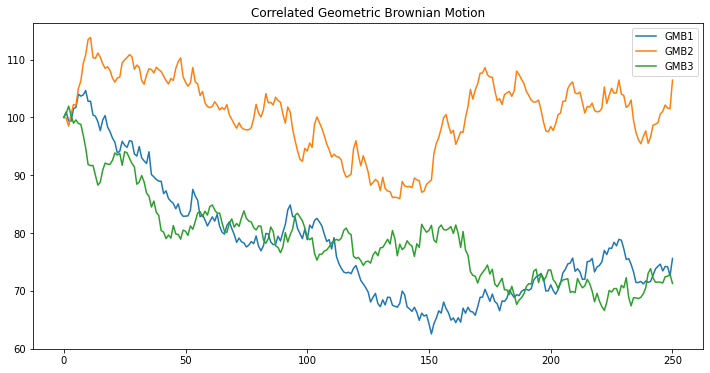

In [25]:
plt.figure(figsize = (12, 6))
x=np.arange(0,251,1)
plt.plot(x,gb1,label='GMB1')
plt.plot(x,gb2,label='GMB2')
plt.plot(x,gb3,label='GMB3')
plt.title('Correlated Geometric Brownian Motion')
plt.legend()

I choose path1 has positive correlation with path2, and path3 has negative correlation with path2. We can see When path2 goes up, path1 also goes up, while path3 goes down.